In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3330, done.
remote: Counting objects: 100% (601/601), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 3330 (delta 523), reused 452 (delta 382), pack-reused 2729 (from 1)
Receiving objects: 100% (3330/3330), 232.17 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (2573/2573), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 

In [2]:
!pip install xopt==2.3.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typegua

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from scipy.stats import qmc
from split_and_delay import SND

import torch
import gpytorch
import botorch

import warnings
warnings.filterwarnings("ignore")



from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.generators.bayesian import ExpectedImprovementGenerator, UpperConfidenceBoundGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

import math
import pandas as pd

In [4]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum
    my_intensity *= (1.0 + np.random.randn() * 0.01)

    do_centroid = snd.get_IP_r()
    do_centroid *= (1.0 + np.random.randn() * 0.01)
    # do_centroid_x = snd.get_IP_cx()
    # do_centroid_y = snd.get_IP_cy()


    result.append( (np.log(do_centroid*1e6) - np.log(my_intensity*10000)).item())

  return torch.tensor(result, dtype=torch.float)

In [5]:
def get_snd_outputs_detailed(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()

    result.append([do_centroid*1e6, my_intensity])

  return torch.tensor(result, dtype=torch.float)

In [6]:
def eval_function(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [66]:
low = 0.0
high = 1.0
n_init = 64
vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high],
                "x5": [low, high],
                "x6": [low, high],
                "x7": [low, high],
                "x8": [low, high]
                 },
    objectives = {"f": "MINIMIZE"},
  )

In [67]:
evaluator = Evaluator(function=eval_function)
generator = ExpectedImprovementGenerator(
    vocs=vocs, turbo_controller="optimize"
)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [68]:
# X.generator.turbo_controller.scale_factor = 1.25
# X.generator.turbo_controller.success_tolerance = 10

# print(X.generator.turbo_controller.scale_factor)
# print(X.generator.turbo_controller.success_tolerance) #number of successes to trigger a trust region contraction
# print(X.generator.turbo_controller.failure_tolerance)

In [69]:
# X.random_evaluate(n_init)
sampler = qmc.LatinHypercube(d=8)
xs = sampler.random(n=n_init)
init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.352822,0.736711,0.989062,0.746363,0.297487,0.890813,0.555735,0.677946,-9.673117,0.354748,False
1,0.820468,0.314601,0.201309,0.761196,0.099583,0.007572,0.324086,0.850453,-8.004987,0.354492,False
2,0.463367,0.090766,0.080562,0.685058,0.586312,0.680385,0.098604,0.953861,-12.834963,0.369821,False
3,0.893058,0.799667,0.262877,0.236186,0.089855,0.162168,0.608957,0.720394,-9.183695,0.360456,False
4,0.123318,0.234263,0.155625,0.604756,0.900451,0.827077,0.592176,0.230765,-8.435005,0.357801,False
...,...,...,...,...,...,...,...,...,...,...,...
59,0.166895,0.986742,0.216555,0.481447,0.174309,0.805644,0.183607,0.830423,-7.959459,0.378960,False
60,0.753760,0.621116,0.541695,0.983109,0.427104,0.189506,0.435284,0.256537,-8.527493,0.466050,False
61,0.061413,0.754676,0.440931,0.774564,0.910915,0.792536,0.564174,0.134346,-7.380328,0.583959,False
62,0.452583,0.169828,0.043764,0.731440,0.953447,0.732825,0.373324,0.504630,-12.778145,0.543679,False


In [70]:
X.generator.train_model()
X.generator.turbo_controller.update_state(X.generator.data)
X.generator.turbo_controller.get_trust_region(X.generator.model)

tensor([[0.5118, 0.3955, 0.0000, 0.6572, 0.3722, 0.3345, 0.5003, 0.0183],
        [0.5445, 0.7283, 0.2069, 0.9818, 0.6866, 0.5923, 0.8519, 0.3907]],
       dtype=torch.float64)

In [71]:
# X.generator.train_model()
# X.generator.turbo_controller.update_state(X.generator.data)
# X.generator.turbo_controller.get_trust_region(X.generator.model)

In [72]:
for i in range(150):
  if i % 10 == 0:
    print(f"Step: {i+1}")
  model = X.generator.train_model()
  trust_region = X.generator.turbo_controller.get_trust_region(generator.model)\
        .squeeze()
  scale_factor = X.generator.turbo_controller.length
  region_width = trust_region[1] - trust_region[0]
  best_value = X.generator.turbo_controller.best_value

  n_successes = X.generator.turbo_controller.success_counter
  n_failures = X.generator.turbo_controller.failure_counter

  acq = X.generator.get_acquisition(model)

  X.step()

Step: 1
Step: 11
Step: 21
Step: 31
Step: 41
Step: 51
Step: 61
Step: 71
Step: 81
Step: 91
Step: 101
Step: 111
Step: 121
Step: 131
Step: 141


In [73]:
X.generator.turbo_controller

OptimizeTurboController(vocs=VOCS(variables={'x1': [0.0, 1.0], 'x2': [0.0, 1.0], 'x3': [0.0, 1.0], 'x4': [0.0, 1.0], 'x5': [0.0, 1.0], 'x6': [0.0, 1.0], 'x7': [0.0, 1.0], 'x8': [0.0, 1.0]}, constraints={}, objectives={'f': 'MINIMIZE'}, constants={}, observables=[]), dim=8, batch_size=1, length=0.0078125, length_min=0.0078125, length_max=2.0, failure_counter=1, failure_tolerance=4, success_counter=0, success_tolerance=4, center_x={'x1': 0.5224970338045849, 'x2': 0.5599692174556629, 'x3': 0.00021516476000811387, 'x4': 0.9944075491743294, 'x5': 0.4487893009544626, 'x6': 0.410937899558675, 'x7': 0.53252679847086, 'x8': 0.4716174088531926}, scale_factor=2.0, tkwargs={'dtype': torch.float64}, name='optimize', best_value=-20.40312385559082)

In [74]:
X.data

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.352822,0.736711,0.989062,0.746363,0.297487,0.890813,0.555735,0.677946,-9.673117,0.354748,False
1,0.820468,0.314601,0.201309,0.761196,0.099583,0.007572,0.324086,0.850453,-8.004987,0.354492,False
2,0.463367,0.090766,0.080562,0.685058,0.586312,0.680385,0.098604,0.953861,-12.834963,0.369821,False
3,0.893058,0.799667,0.262877,0.236186,0.089855,0.162168,0.608957,0.720394,-9.183695,0.360456,False
4,0.123318,0.234263,0.155625,0.604756,0.900451,0.827077,0.592176,0.230765,-8.435005,0.357801,False
...,...,...,...,...,...,...,...,...,...,...,...
209,0.522301,0.557814,0.002544,0.988436,0.451033,0.413899,0.533606,0.474859,-19.382542,0.346985,False
210,0.521723,0.554130,0.005617,0.996739,0.452559,0.406129,0.533899,0.473601,-17.050320,0.335011,False
211,0.521660,0.562737,0.001441,0.995329,0.446504,0.414635,0.534838,0.475639,-17.797941,0.502014,False
212,0.521784,0.559621,0.001190,0.988502,0.445261,0.410764,0.532593,0.474247,-18.801729,0.454675,False


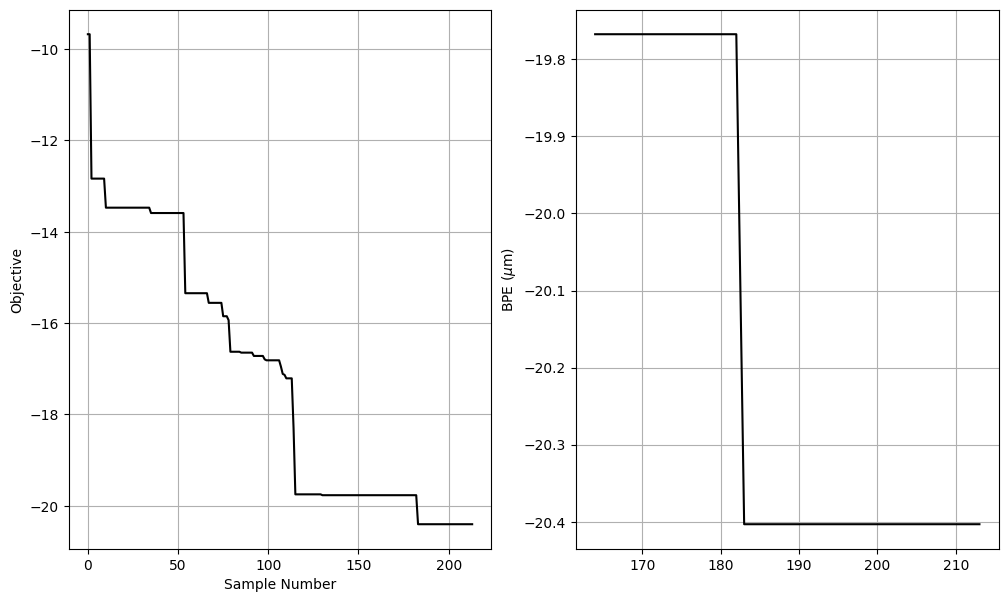

In [75]:
y1 = X.generator.data["f"]
y1_mins = np.minimum.accumulate(y1)


idx = np.arange(len(y1_mins))
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
ax0.plot(idx, y1_mins,'k')
ax0.grid()
ax0.set_xlabel("Sample Number")
ax0.set_ylabel("Objective")

ax1.plot(idx[-50:], y1_mins[-50:],'k')
ax1.grid()
ax1.set_ylabel("BPE ($\mu$m)");

In [76]:
min_idx = np.argmin(X.generator.data["f"])
min_val = X.generator.data["f"][min_idx]
X_min = [X.generator.data["x1"][min_idx],
         X.generator.data["x2"][min_idx],
          X.generator.data["x3"][min_idx],
         X.generator.data["x4"][min_idx],
         X.generator.data["x5"][min_idx],
         X.generator.data["x6"][min_idx],
          X.generator.data["x7"][min_idx],
          X.generator.data["x8"][min_idx]
         ]
inputs = np.array(X_min)
inputs = inputs[np.newaxis,:]
outs = get_snd_outputs_detailed(inputs)
print("Optimum Inputs: ", X_min)
print("BPE: ", outs[0][0].item())
print("Intensity:", outs[0][1].item())
print(outs[0][0].item()/outs[0][1].item(), min_val)

Optimum Inputs:  [0.5224970338045849, 0.5599692174556629, 0.00021516476000811387, 0.9944075491743294, 0.4487893009544626, 0.410937899558675, 0.53252679847086, 0.4716174088531926]
BPE:  0.780438244342804
Intensity: 55934.6796875
1.3952672093645909e-05 -20.40312385559082


In [77]:
def plot_optima_from_generator_data(X, plot=True):
  """
  Takes Xopt object, returns and plots the (noise-less) data for
  beam position error and intensity.
  Args:
    X: Xopt object
    plot: boolean to plot or not
  Returns:
    tuple of beam position error sample and intensity sample histories.
  """
  features = ["x1",  "x2", "x3", "x4", "x5",  "x6", "x7", "x8"]
  points = X.generator.data[features].to_numpy()
  outs = get_snd_outputs_detailed(points).numpy()
  bpe_vals,  intensity_vals =   outs[:,0], outs[:,1]
  bpe_optima = np.minimum.accumulate(bpe_vals)
  intensity_optima = np.maximum.accumulate(intensity_vals)

  if plot:
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    ax1.plot(bpe_optima, 'k')
    ax1.scatter(np.arange(len(bpe_optima)), bpe_vals)
    ax1.set_xlabel("Sample Number")
    ax1.set_ylabel("BPE (microns)")


    ax2.plot(intensity_optima, 'k')
    ax2.scatter(np.arange(len(intensity_optima)), intensity_vals)
    ax2.set_xlabel("Sample Number")
    ax2.set_ylabel("Intensity")
    plt.show()

  return bpe_vals,  intensity_vals

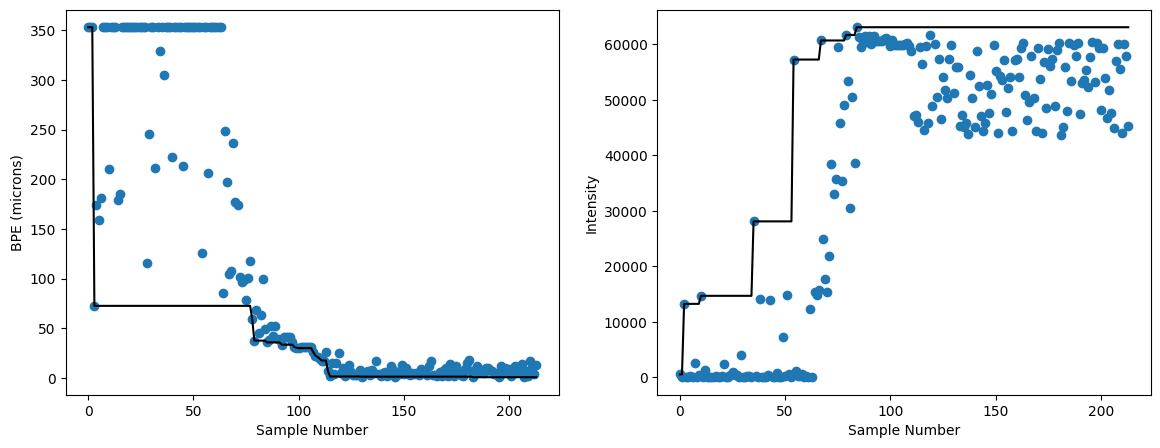

In [78]:
temp = plot_optima_from_generator_data(X)

In [79]:
np.min(temp[0]), np.max(temp[1])

(0.78043824, 63055.844)

In [ ]:
# 1% noise, 64 init, 150 chain, weights = [1e6, 1e4]
# Seems to over-value the BPE minimum compared to the intensity maximum.
# BPE:  0.6
# Intensity: 38713

# BPE:  0.37
# Intensity: 28000

# BPE:  0.95
# Intensity: 28893

# BPE:  0.56
# Intensity: 66816

# BPE:  0.78
# Intensity: 59000
#==========================================================================
# 1% noise, 64 init, 150 chain, weights = [1e6, 1e2]

#==========================================================================
# 1% noise, 64 init, 150 chain, weights = [1e6, 1e6]

In [ ]:
#Step 1. Track len_min and max for the TC
#Step 2. Instead of optimize setting, use the safety version of turbo.
#Step 3. Use the 'use_low_noise_prior' flag for the gp_constructor.